# Iron Deficiency in Households with Children in Northern Uganda

In [44]:
# Loading in necessary packages

!pip install -r requirements.txt
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

In [45]:
#Loading in necessary dataframes

InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['i','t','m'])
x.columns.name = 'j'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

# Take logs of expenditures; call this y
y = np.log(x)

In [46]:
import cfe
result = cfe.Regression(y=np.log(x.stack()),d=z)
result.to_pickle('./foo.pickle')

import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

use = fct.index.intersection(qhat.columns)

nutrients = qhat[use]@fct.loc[use,:]

z = z[rdi.columns.tolist()]
filtered_z = z[(z['F 00-03']!=0) | (z['M 00-03']!=0) | (z['F 04-08']!=0) | (z['M 04-08']!=0)]
filtered_z = filtered_z.xs('2019-20',level='t',drop_level=False)

filtered_hh_rdi = filtered_z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
filtered_hh_rwi = filtered_hh_rdi*7

use_nutrients = nutrients.columns.intersection(filtered_hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/filtered_hh_rwi[use_nutrients]).dropna()

## Introduction:

We are exploring the percentage of Uganda households with children that suffer from iron deficiency, and exploring possible solutions to combat it. We chose iron as a nutrient because a significant amount of households fail to hit the recommended daily amount as shown by the histogram below.

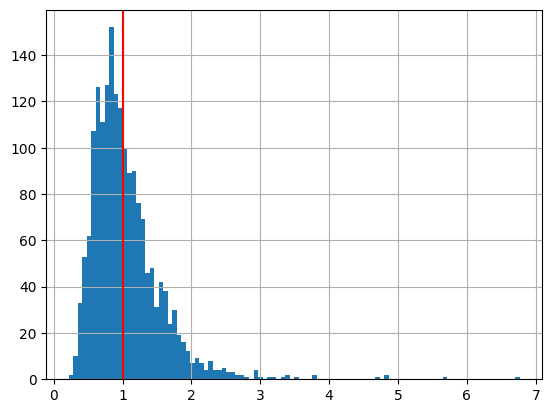

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
nutrient_ratio['Iron'].hist(bins=100)
plt.axvline(x = 1, color = 'r', label = 'axvline - full height')

In [48]:
# Below is the percentage of households with at least one child 0-8 in Uganda that are below recommended iron levels
percent_households_under_rdi = len(nutrient_ratio[nutrient_ratio['Iron']<1])/len(nutrient_ratio['Iron'])
percent_households_under_rdi

0.5562841530054645

## Iron content of beans and millet

Beans (fresh and dry) and millet have significant amounts of iron in them, as shown by the FCT results below

In [49]:
fct.loc[['Beans (dry)', 'Beans (fresh)', 'Millet']]['Iron']

j
Beans (dry)      30.0
Beans (fresh)    51.0
Millet           30.0
Name: Iron, dtype: float64

However, these two products have very different elasticities:

In [ ]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median


# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean()
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,p=pbar,j='Millet'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p
pbar


# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)



Text(0.5, 0, 'Quantities of Beans Demanded')

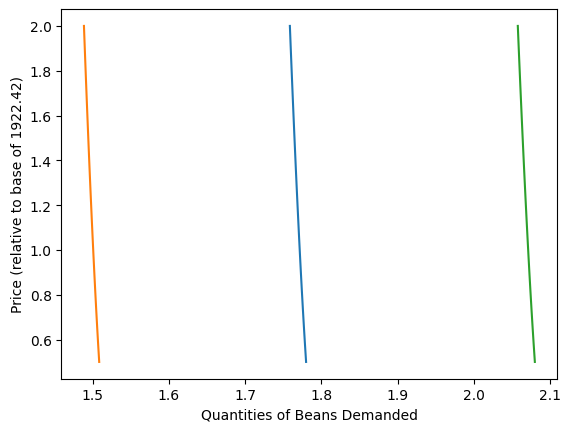

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Beans'  # Good we want demand curve for

# Demand for Beans for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)
# Demand for Beans for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)
# Demand for Beans for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

Text(0.5, 0, 'Quantities of Millet Demanded')

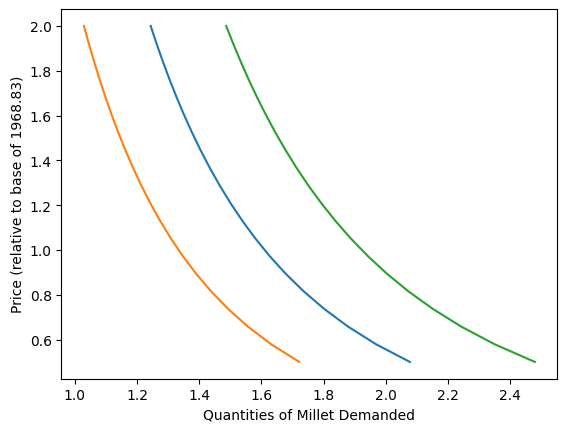

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Millet'  # Good we want demand curve for

# Demand for Beans for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)
# Demand for Beans for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)
# Demand for Beans for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

In this project, we will exlore how different policies regarding beans and millet may have different effects on household iron intakes.

## Beans

Beans have a high iron content, and specifically we want to see how much iron intake would change if the iron content of beans were increased, which is what the "iron beans" do. Let's create the same stats as above but with a 30% increase in the iron content of fresh and dry beans.

In [51]:
def increase_iron_content(fct, food_items, nutrient='Iron', increase_percent=30):
    new_fct = fct.to_dict()
    for food_item in food_items:
        if food_item in fct.index:
            print(f"Before update: {food_item} iron content = {fct.loc[food_item, nutrient]}")
            new_fct[nutrient][food_item] = fct.loc[food_item][nutrient] * (1 + (increase_percent / 100))
            print(f"After update: {food_item} iron content = {new_fct[nutrient][food_item]}")
        else:
            print(f"{food_item} not found in FCT.")
    return pd.DataFrame(new_fct)

# Test the function with debug statements
updated_fct = increase_iron_content(fct, ['Beans (dry)', 'Beans (fresh)', 'Millet'], nutrient='Iron', increase_percent=30)

Before update: Beans (dry) iron content = 30.0
After update: Beans (dry) iron content = 39.0
Before update: Beans (fresh) iron content = 51.0
After update: Beans (fresh) iron content = 66.3
Before update: Millet iron content = 30.0
After update: Millet iron content = 39.0


In [52]:
print(fct['Iron']['Millet'])
print(fct['Iron']['Beans (dry)'])
print(fct['Iron']['Beans (fresh)'])
print('--------------')
print(updated_fct['Iron']['Millet'])
print(updated_fct['Iron']['Beans (dry)'])
print(updated_fct['Iron']['Beans (fresh)'])

30.0
30.0
51.0
--------------
39.0
39.0
66.3


In [53]:
updated_fct

,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,39.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,66.3,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomatoes,180,9.0,10.0,150,100,39.0,3.0,5.94,0.19,0.37,420,0.0,0.80,127,2.0
Waragi,2630,0.0,0.0,0,0,0.0,0.0,0.00,0.00,0.00,0,0.0,0.00,0,0.0
Watermelon,300,6.1,4.0,30,70,75.5,2.4,1.78,0.21,0.33,280,0.0,0.45,81,1.0
Wheat (flour),3640,103.0,30.0,260,150,763.0,12.0,12.50,0.40,1.20,0,0.0,0.44,0,7.0


In [54]:
import cfe.regression as rgsn

r = rgsn.read_pickle('uganda_2019-20.pickle')

In [55]:
use = updated_fct.index.intersection(qhat.columns)

nutrients_2 = qhat[use]@updated_fct.loc[use,:]

z = z[rdi.columns.tolist()]
filtered_z = z[(z['F 00-03']!=0) | (z['M 00-03']!=0) | (z['F 04-08']!=0) | (z['M 04-08']!=0)]
filtered_z = filtered_z.xs('2019-20',level='t',drop_level=False)

filtered_hh_rdi = filtered_z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
filtered_hh_rwi = filtered_hh_rdi*7

use_nutrients2 = nutrients_2.columns.intersection(filtered_hh_rwi.columns)

nutrient_ratio_2 = (nutrients_2[use_nutrients2]/filtered_hh_rwi[use_nutrients2]).dropna()

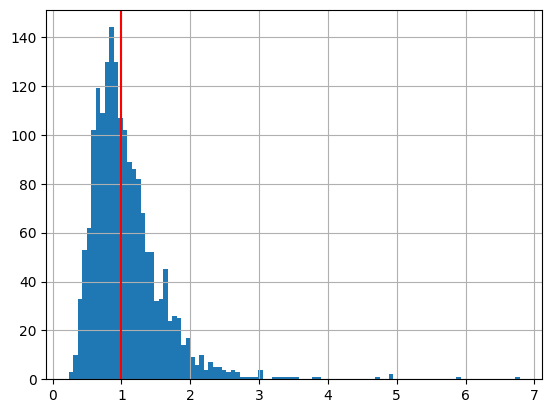

In [56]:
nutrient_ratio_2['Iron'].hist(bins=100)
plt.axvline(x = 1, color = 'r', label = 'axvline - full height')

In [57]:
percent_households_under_rdi_updated = len(nutrient_ratio_2[nutrient_ratio_2['Iron']<1])/len(nutrient_ratio_2['Iron'])
percent_households_under_rdi_updated

0.5295081967213114

In [58]:
nutrient_ratio_2['Iron']

i                                 t        m       
00c9353d8ebe42faabf5919b81d7fae7  2019-20  Eastern     0.757565
0d0e29faff394154a69562b4527b48b8  2019-20  Eastern     1.038396
0e03e253c35d4333a1ffad2df9d38850  2019-20  Eastern     0.758040
1013000202                        2019-20  Central     0.790738
1021000709                        2019-20  Central     0.913523
                                                         ...   
ad9b7c4ba614444bb8004eb658693c9f  2019-20  Eastern     1.204087
bfd8253bd59c4f3199fb4b83b9cee7a6  2019-20  Eastern     1.652089
bfdf0d66403440ceab439b1e1c47cdea  2019-20  Eastern     0.831355
d24fa50d02c041969a42102d8ebdadc9  2019-20  Eastern     1.136175
e07bc322c4884559b4b8ca75c945dd3e  2019-20  Northern    0.897645
Name: Iron, Length: 1830, dtype: float64

In [59]:
nutrient_ratio['Iron']

i                                 t        m       
00c9353d8ebe42faabf5919b81d7fae7  2019-20  Eastern     0.736215
0d0e29faff394154a69562b4527b48b8  2019-20  Eastern     1.010272
0e03e253c35d4333a1ffad2df9d38850  2019-20  Eastern     0.733177
1013000202                        2019-20  Central     0.761054
1021000709                        2019-20  Central     0.888548
                                                         ...   
ad9b7c4ba614444bb8004eb658693c9f  2019-20  Eastern     1.176635
bfd8253bd59c4f3199fb4b83b9cee7a6  2019-20  Eastern     1.608034
bfdf0d66403440ceab439b1e1c47cdea  2019-20  Eastern     0.809916
d24fa50d02c041969a42102d8ebdadc9  2019-20  Eastern     1.105949
e07bc322c4884559b4b8ca75c945dd3e  2019-20  Northern    0.891731
Name: Iron, Length: 1830, dtype: float64